## Модель оценки рыночной стоимости автомобиля
Предсказываем рыночную стоимость автомобиля на основе исторических данных: технические характеристики, комплектации и цены. автомобилей. В качестве целевой метрики использует RMSE. Кроме целевой метрики важна также скорость модели, поэтому я использую 3 алгоритма машинного обучения.

## Описание данных

#### Признаки
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
NotRepaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
##### Целевой признак  
Price — цена (евро)  

## Структура проекта
[1. Подготовка данных](1)  
- [1.1 Загрузка](1.1)  
- [1.2 Дубликаты данных](1.2)  
- [1.3 Преобразование данных](1.3)  
- [1.4 Пропуски данных](1.4)  
- [1.5 Перекодирование](1.5)    

[2. Обучение моделей](2)
- [2.1 Деление на выборки](2.1)
- [2.2 Baseline](2.2)
- [2.3 Модели из коробки](2.3)
- [2.4 Ручные модели](2.4)

[3. Анализ моделей](3)  
[4. Итоговый вывод](4)   


# <a name="1">Подготовка данных</a>

## <a name="1.1">Загрузка</a>

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
!pip install -U scikit-learn
from sklearn.preprocessing import OrdinalEncoder
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (0.24.1)


In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
df.describe(include = 'all').loc['unique', :][df.describe(include = 'all').loc['unique', :] > 0]

DateCrawled    271174
VehicleType         8
Gearbox             2
Model             250
FuelType            7
Brand              40
NotRepaired         2
DateCreated       109
LastSeen       179150
Name: unique, dtype: object

## <a name="1.2"> Дубликаты данных</a>

In [7]:
df.duplicated().sum()

4

In [8]:
df = df.drop_duplicates()

## <a name="1.3"> Пропуски данных и перекодирование</a>

-попробуем поискать пропуски

In [9]:
df.isna().sum()[df.isna().sum()>0]

VehicleType    37490
Gearbox        19833
Model          19705
FuelType       32895
NotRepaired    71154
dtype: int64

$ VehicleType, Gearbox, RegistrationYear, Model, FuelType, Power, Brand $
- эти 7 колонок взаимозависимы, и их различная комбинация, даёт ответ на пропуск того или иного значения. Лучший вариант заполнения использоваться метод ближайших соседей, соответственно KNNImputer, !НО с таким обёмом данных он работает часами.
Заполнение на основе других столбцов работает при использовании более 3-4 столбцов, но это объём. 
Я заполню пропуски строковым значением Nan.

- столбец NotRepaired. Думаю заполнить наибольшим значением no.


In [10]:
f_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand'] 
f_col_cl = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand'] 

!импутер занимает 17 минут

In [11]:
df[f_col_cl] = df[f_col_cl].fillna('Nan')

In [12]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

In [13]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

## <a name="1.4"> Деление на выборки</a>

In [14]:
pd.to_datetime(df['DateCrawled']).is_monotonic

False

In [15]:
df = df.sort_values(by = 'DateCrawled')

In [16]:
pd.to_datetime(df['DateCrawled']).is_monotonic

True

In [17]:
train, valid = train_test_split(df, test_size=0.4, random_state=42, shuffle=False)

In [18]:
train.shape

(212619, 16)

In [19]:
valid.shape

(141746, 16)

In [20]:
valid, test = train_test_split(valid, test_size=0.5, random_state=42, shuffle = False)

In [21]:
test.shape

(70873, 16)

In [22]:
valid.shape

(70873, 16)

In [23]:
pd.to_datetime(test['DateCrawled']).is_monotonic

True

## <a name="1.3"> Преобразование данных</a>

- преобразование дат в Unix

In [24]:
date_col = ['DateCrawled', 'LastSeen', 'DateCreated']
for i in [train, valid, test]:
    i[date_col] = i[date_col].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')
    i[date_col] = i[date_col].astype(np.int64) // 10**9
test[date_col].dtypes

DateCrawled    int64
LastSeen       int64
DateCreated    int64
dtype: object

- преобразование данных в категориальные

In [25]:
train[f_col] = train[f_col].astype('category')
valid[f_col] = valid[f_col].astype('category')
test[f_col] = test[f_col].astype('category')

## <a name="1.6"> Анализ данных</a>

- Боксплот для таргета обучающей выборки

Text(0.5, 0, 'Цена')

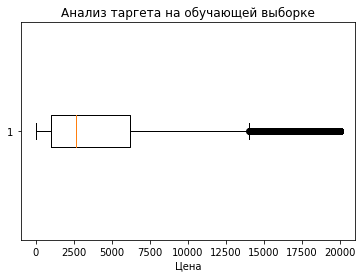

In [26]:
plt.boxplot(train["Price"], vert = False)
plt.title('Анализ таргета на обучающей выборке')
plt.xlabel('Цена')

- найдем точное значение границ усов

In [27]:
q1 = train["Price"].quantile(0.25)
q3 = train["Price"].quantile(0.75)
iqr = q3-q1
print(q3 + iqr*1.5)

14000.0


- обрежим данные по усам

In [28]:
train = train.query('Price <= 14000 and Price > 0')

- уберём нулевый значения в валидационной и тестовой выборках

In [29]:
valid = valid.query('Price > 0')
test = test.query('Price > 0')

- Боксплот по Году выпуска

Text(0.5, 0, 'Год выпуска')

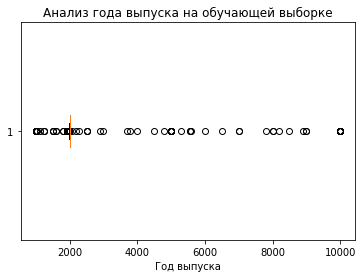

In [30]:
plt.boxplot(train["RegistrationYear"], vert = False)
plt.title('Анализ года выпуска на обучающей выборке')
plt.xlabel('Год выпуска')

In [31]:
q1 = train["RegistrationYear"].quantile(0.25)
q3 = train["RegistrationYear"].quantile(0.75)
iqr = q3-q1
print(q1 - iqr*1.5)
print(q3 + iqr*1.5)

1987.0
2019.0


- нижнюю планку начну с 1980 года.

In [32]:
train = train.query('RegistrationYear <= 2019 and RegistrationYear > 1980')

- Боксплот по Мощности

Text(0.5, 0, 'Мощность двигателя (л.с)')

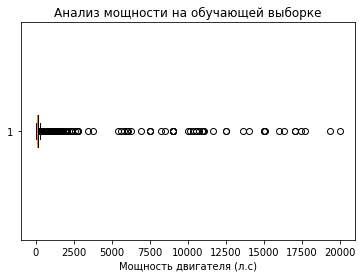

In [33]:
plt.boxplot(train["Power"], vert = False)
plt.title('Анализ мощности на обучающей выборке')
plt.xlabel('Мощность двигателя (л.с)')

In [34]:
q1 = train["Power"].quantile(0.25)
q3 = train["Power"].quantile(0.75)
iqr = q3-q1
print(q1 - iqr*1.5)
print(q3 + iqr*1.5)

-40.0
248.0


- увеличю срез до 500 л.с, считаю это более оптимальным значением
- нижнюю планку начну с 50 л.с.

In [35]:
train = train.query('Power <= 500 and Power >= 50')

## Вывод
- данные загружены;
- дубликаты удалены;
- пропуски в большинстве столбцов заполнены 0 значениме, в одном столбце заполнены модой;
- деление на выборки с учетом времени отражения в базе;
- преобразованы даты в unix формат, категориальные признаки в формат category;
- проанализированы столбцы, цена, мощность, год выпуска. Удалены аномальные значения. По тестовой и валидационой выборке; удалены только нули в столбца цена, для более точного вычисления RMSE.


# <a name="2">Обучение моделей</a>

## <a name="2.1"> Признаки и Таргет</a>

In [36]:
features_train = train.drop('Price', axis= 1)
target_train = train['Price']

features_valid = valid.drop('Price', axis= 1)
target_valid = valid['Price']

features_test = test.drop('Price', axis= 1)
target_test = test['Price']

- деление выборок на признаки и таргет

## <a name="2.2"> Baseline</a>

### Средняя

In [37]:
%%time
mean_train = [target_train.mean()]

CPU times: user 729 µs, sys: 67 µs, total: 796 µs
Wall time: 606 µs


In [38]:
print('RMSE -', mean_squared_error(target_valid, np.array(mean_train * target_valid.shape[0])) ** 0.5)

RMSE - 4571.250140456424


- посчитал baseline на основе средней

## <a name="2.3"> Модели из коробки</a>

### CatBoost

- обучение

In [39]:
model_cb = CatBoostRegressor(random_state = 42, cat_features = f_col, iterations=500, verbose = 100, 
                             eval_metric = 'RMSE', learning_rate = 0.25, depth=8)

In [40]:
%%time
model_cb.fit(features_train, target_train)

0:	learn: 2921.6220625	total: 983ms	remaining: 8m 10s
100:	learn: 1261.6745808	total: 1m 16s	remaining: 5m 2s
200:	learn: 1197.0303892	total: 2m 31s	remaining: 3m 45s
300:	learn: 1153.3462409	total: 3m 49s	remaining: 2m 31s
400:	learn: 1120.3330757	total: 5m 7s	remaining: 1m 16s
499:	learn: 1089.4305635	total: 6m 25s	remaining: 0us
CPU times: user 5min 53s, sys: 33.1 s, total: 6min 27s
Wall time: 6min 29s


- валидация

In [41]:
%%time
pred = model_cb.predict(features_valid)

CPU times: user 827 ms, sys: 36.7 ms, total: 864 ms
Wall time: 803 ms


In [42]:
print('RMSE -', mean_squared_error(target_valid, pred) ** 0.5)

RMSE - 1968.3109341596457


- тестирование

In [43]:
%%time
pred_test = model_cb.predict(features_test)

CPU times: user 822 ms, sys: 16.9 ms, total: 839 ms
Wall time: 796 ms


In [44]:
print('RMSE -', mean_squared_error(target_test, pred_test) ** 0.5)

RMSE - 1948.0938172669596


### LightGBM

- обучение

In [45]:
model = lgb.LGBMRegressor(random_state=42, learning_rate = 0.3, n_estimators = 400, max_depth = 3)

In [46]:
%%time
model.fit(features_train, target_train)

CPU times: user 15.1 s, sys: 0 ns, total: 15.1 s
Wall time: 15.3 s


LGBMRegressor(learning_rate=0.3, max_depth=3, n_estimators=400, random_state=42)

- валидация

In [47]:
%%time
pred = model.predict(features_valid)

CPU times: user 2.55 s, sys: 0 ns, total: 2.55 s
Wall time: 2.59 s


In [48]:
print('RMSE -', mean_squared_error(target_valid, pred) ** 0.5)

RMSE - 1974.036924992945


- тестирование

In [49]:
%%time
pred_test = model.predict(features_test)

CPU times: user 2.55 s, sys: 0 ns, total: 2.55 s
Wall time: 2.58 s


In [50]:
print('RMSE -', mean_squared_error(target_test, pred_test) ** 0.5)

RMSE - 1948.2441094858311


### RandomForestRegressor

- перекодирование

In [51]:
df1 = pd.concat([features_train, features_valid, features_test])
enc = OrdinalEncoder()
df1[f_col] = enc.fit_transform(df1[f_col])
features_train1 = df1.loc[features_train.index.values]
features_valid1 = df1.loc[features_valid.index.values]
features_test1 = df1.loc[features_test.index.values]

- обучение

In [52]:
model = RandomForestRegressor(random_state=42)

In [53]:
%%time
model.fit(features_train1, target_train)

CPU times: user 2min 19s, sys: 0 ns, total: 2min 19s
Wall time: 2min 20s


RandomForestRegressor(random_state=42)

- валидация

In [54]:
%%time
pred = model.predict(features_valid1)

CPU times: user 3.16 s, sys: 0 ns, total: 3.16 s
Wall time: 3.18 s


In [55]:
print('RMSE -', mean_squared_error(target_valid, pred) ** 0.5)

RMSE - 2243.998830007772


- тестирование

In [56]:
%%time
pred_test = model.predict(features_test1)

CPU times: user 3.15 s, sys: 0 ns, total: 3.15 s
Wall time: 3.26 s


In [57]:
print('RMSE -', mean_squared_error(target_test, pred_test) ** 0.5)

RMSE - 2258.1642806494456


- настройки гиперпараметров этой модели не дают результат лучше.

## Вывод
- Использованы 3 модели. Я не стал перекодировать данные еще в начале, так как хотел проверить как на них работает CatBoost и LightGBM. 
- Для метода рандом форест, я перекодировал.
- Я сначала обучил данные на базовым моделях без настроек гиперпараметров и далее с настройками. Все данные я учел в таблице Анализа моделей.

# <a name="3"> Анализ моделей</a>

In [58]:
an = pd.DataFrame(columns = ['Время обучения (базовое)', 'Время обучения (с настройками)', 'RMSE_тестовый(базовый)', 'RMSE_тестовый(с настройками)'],
            index = ['CatBoost', 'LightGBM', 'RandomForestRegressor'])
an.loc['CatBoost', 'Время обучения (базовое)'] = '9m 15s'
an.loc['CatBoost', 'RMSE_тестовый(базовый)'] = '2016.92'
an.loc['LightGBM', 'Время обучения (базовое)'] = '13s'
an.loc['LightGBM', 'RMSE_тестовый(базовый)'] = '2042.36'
an.loc['RandomForestRegressor', 'Время обучения (базовое)'] = '2m 25s'
an.loc['RandomForestRegressor', 'RMSE_тестовый(базовый)'] = '2257.84'
an.loc['LightGBM', 'Время обучения (с настройками)'] = '15.3s'
an.loc['LightGBM', 'RMSE_тестовый(с настройками)'] = '1948.24'
an.loc['CatBoost', 'Время обучения (с настройками)'] = '6m 32s'
an.loc['CatBoost', 'RMSE_тестовый(с настройками)'] = '1948.09'
an.loc['RandomForestRegressor', 'Время обучения (с настройками)'] = '2m 25s'
an.loc['RandomForestRegressor', 'RMSE_тестовый(с настройками)'] = '2257.84'

In [59]:
an

,Время обучения (базовое),Время обучения (с настройками),RMSE_тестовый(базовый),RMSE_тестовый(с настройками)
CatBoost,9m 15s,6m 32s,2016.92,1948.09
LightGBM,13s,15.3s,2042.36,1948.24
RandomForestRegressor,2m 25s,2m 25s,2257.84,2257.84


## Выводы
- Лучше всего себя показала модель LightGBM в своей базовой версии. Конечно если уже нам нужно качество и нам не жалко времени то будем использовать CatBoost. Хотя я бы все равно докручивал LightGBM.

# <a name="4"> Итоговый вывод </a>
- были загруженны и предобработаны данные, в частности:
    - удалены дубликаты; 
    - пропуски в большинстве случаев заполнены 0;
    - деление на выборки с учетом времени отражения в базе;
    - преобразованы даты в unix формат, категориальные признаки в формат category;
    - проведен анализ, аномальные значения удалены.

- использованы 3 модели для обучения (CatBoost,  LightGBM и RandomForestRegressor).
    - CatBoost и  LightGBM съели текстовые признаки и выдали корректные результаты;
    - RandomForestRegressor  с этой задачей не справился, пришлось ему помочь, перекодировав данные;
    - Были использованы различные настройки моделей, для улучшения их точности. RandomForestRegressor правда это не помогло.

- Лучшей моделью скорость-качество - качество является LightGBM.
